# tobac example: 
## Tracking deep convection based on VIS from geostationary satellite retrievals

This example notebook demonstrates the use of tobac to track isolated deep convective clouds based on radiances within the VIS using channel 2 (red light - 600 nm) of the GOES-16 imaging instrument in 5-min resolution. The study area is loacted within the CONUS extent of the GOES-E for investigating the formation of deep convection over the Carribean, following the [EUREC4A](eurec4a.eu) initiaive. 

The data used in this example is saved on the cloud of the Amazon Web Services, providing an efficient way of processing satellite data without facing the need of downloading the data. 

In this example, the [Cloud and Moisture Imagery data](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C01502) (ABI-L2-CMIPC) data set is used for the cloud tracking. The product contains one or more Earth-view images with pixel values identifying brightness values that are scaled to support visual analysis. Also, the data includes quality information. 

Further information on the AWS and provided data sets can be found [here](https://registry.opendata.aws/noaa-goes/).

**Configurations needed for conducting the example:**

In [19]:
# Import libraries
import requests
import netCDF4
import boto3
from botocore import UNSIGNED
from botocore.config import Config
from pyproj import Proj, transform, Transformer
from pyproj import transformer

import xarray
import rioxarray
import rasterio
import numpy as np
from numpy import ma
import pandas as pd
import os
from six.moves import urllib
from glob import glob
from scipy import interpolate
import cv2 as cv

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import tobac itself:
import tobac

In [3]:
# Disable a few warnings:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

**Build access to Amazon Web Server where GOES-16 data are stored:**

In [4]:
# For acessing data from AWS bucket define bucket specifics:
bucket_name = 'noaa-goes16'
product_name = 'ABI-L2-CMIPC'
year = 2020
day_of_year = 45
hour = 18
band = 2

In [5]:
# Initialize an s3 client:
s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))

In [6]:
# Define function for generating file name keys for the S3 bucket:
def get_s3_keys(bucket, s3_client, prefix = ''):
    """
    Generate the keys in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch keys that start with this prefix (optional).
    """
    
    kwargs = {'Bucket': bucket}

    if isinstance(prefix, str):
        kwargs['Prefix'] = prefix

    while True:
        resp = s3_client.list_objects_v2(**kwargs)
        for obj in resp['Contents']:
            key = obj['Key']
            if key.startswith(prefix):
                yield key

        try:
            kwargs['ContinuationToken'] = resp['NextContinuationToken']
        except KeyError:
            break

In [7]:
# Retrieve the keys for file names:
keys = get_s3_keys(bucket_name,
                   s3_client,
                   prefix = f'{product_name}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M6C{band:02.0f}'
                  )


keys = [key for key in keys][0:6]

In [8]:
# Print the file names of the GOES CMIPC ABI-L2 data for the selected time period
print(keys)

['ABI-L2-CMIPC/2020/045/18/OR_ABI-L2-CMIPC-M6C02_G16_s20200451800585_e20200451803358_c20200451803496.nc', 'ABI-L2-CMIPC/2020/045/18/OR_ABI-L2-CMIPC-M6C02_G16_s20200451805585_e20200451808358_c20200451808493.nc', 'ABI-L2-CMIPC/2020/045/18/OR_ABI-L2-CMIPC-M6C02_G16_s20200451810585_e20200451813358_c20200451813484.nc', 'ABI-L2-CMIPC/2020/045/18/OR_ABI-L2-CMIPC-M6C02_G16_s20200451815585_e20200451818358_c20200451818500.nc', 'ABI-L2-CMIPC/2020/045/18/OR_ABI-L2-CMIPC-M6C02_G16_s20200451820585_e20200451823358_c20200451823498.nc', 'ABI-L2-CMIPC/2020/045/18/OR_ABI-L2-CMIPC-M6C02_G16_s20200451825585_e20200451828358_c20200451828489.nc']


**Request data from AWS S3 server using the keys we defined and store all files to one data set:**

In [9]:
for k in range(len(keys)):
    resp = requests.get(f'https://{bucket_name}.s3.amazonaws.com/{keys[k]}')
    file_name = keys[k].split('/')[-1].split('.')[0]
    nc4_ds = netCDF4.Dataset(file_name, memory = resp.content)
    store = xarray.backends.NetCDF4DataStore(nc4_ds)
    if k == 0:
        DS = xarray.open_dataset(store)    
    else:
        DS2 = xarray.open_dataset(store)
        DS = xarray.combine_nested([DS, DS2], concat_dim=["t"], combine_attrs = "override")

In [10]:
geos_p = DS['goes_imager_projection']
proj_name = DS.goes_imager_projection.grid_mapping_name[0]
h = DS.goes_imager_projection.perspective_point_height
a = DS.goes_imager_projection.semi_major_axis
b = DS.goes_imager_projection.semi_minor_axis
rf = DS.goes_imager_projection.inverse_flattening
lat_0 = DS.goes_imager_projection.latitude_of_projection_origin
lon_0 = DS.goes_imager_projection.longitude_of_projection_origin
sweep = DS.goes_imager_projection.sweep_angle_axis
pstr = '+proj=geos +h=%f +a=%f +b=%f +rf=%f +lat_0=%f +lon_0=%f' \
    % (h, a, b, rf, lat_0, lon_0)

In [11]:
DS.rio.write_crs(pstr, inplace=True)

<xarray.Dataset>
Dimensions:                                           (band: 1, number_of_image_bounds: 2, number_of_time_bounds: 2, t: 6, x: 10000, y: 6000)
Coordinates:
  * t                                                 (t) datetime64[ns] 2020...
  * y                                                 (y) float32 0.1282 ... ...
  * x                                                 (x) float32 -0.1014 ......
    goes_imager_projection                            int64 0
    y_image                                           float32 0.08624
    x_image                                           float32 -0.03136
    band_id                                           (band) int8 2
    band_wavelength                                   (band) float32 0.64
Dimensions without coordinates: band, number_of_image_bounds, number_of_time_bounds
Data variables:
    CMI                                               (t, y, x) float32 nan ....
    DQF                                               (t, y, x) float32 nan ....
    time_bounds                                       (t, number_of_time_bounds) datetime64[ns] ...
    y_image_bounds                                    (t, number_of_image_bounds) float32 ...
    x_image_bounds                                    (t, number_of_image_bounds) float32 ...
    nominal_satellite_subpoint_lat                    (t) float64 0.0 ... 0.0
    nominal_satellite_subpoint_lon                    (t) float64 -75.2 ... -...
    nominal_satellite_height                          (t) float64 3.579e+04 ....
    geospatial_lat_lon_extent                         (t) float32 9.969e+36 ....
    valid_pixel_count                                 (t) float64 5.924e+07 ....
    outlier_pixel_count                               (t) float64 0.0 ... 0.0
    total_number_of_points                            (t) float64 5.925e+07 ....
    min_reflectance_factor                            (t) float64 0.0006142 ....
    max_reflectance_factor                            (t) float64 0.9765 ... ...
    mean_reflectance_factor                           (t) float64 0.1838 ... ...
    std_dev_reflectance_factor                        (t) float64 0.1633 ... ...
    algorithm_dynamic_input_data_container            (t) int32 -2147483647 ....
    percent_uncorrectable_GRB_errors                  (t) float64 0.0 ... 0.0
    percent_uncorrectable_L0_errors                   (t) float64 0.0 ... 0.0
    earth_sun_distance_anomaly_in_AU                  (t) float64 0.9875 ... ...
    processing_parm_version_container                 (t) int32 -2147483647 ....
    algorithm_product_version_container               (t) int32 -2147483647 ....
    esun                                              (t) float64 1.631e+03 ....
    kappa0                                            (t) float64 0.001878 .....
    planck_fk1                                        (t) float64 nan ... nan
    planck_fk2                                        (t) float64 nan ... nan
    planck_bc1                                        (t) float64 nan ... nan
    planck_bc2                                        (t) float64 nan ... nan
    focal_plane_temperature_threshold_exceeded_count  (t) float64 nan ... nan
    maximum_focal_plane_temperature                   (t) float64 nan ... nan
    focal_plane_temperature_threshold_increasing      (t) float64 nan ... nan
    focal_plane_temperature_threshold_decreasing      (t) float64 nan ... nan
Attributes:
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           NSOF
    production_environment:    OE
    spatial_resolution:        0.5km at nadir
    orbital_slot:              GOES-East
    platform_ID:               G

In [12]:
DS = DS[["CMI", "DQF"]]

In [13]:
DS["x"] = DS["x"]*h
DS["y"] = DS["y"]*h

In [14]:
DS_R = DS.rio.reproject("epsg:4326")

In [15]:
DS_R

<xarray.Dataset>
Dimensions:                 (t: 6, x: 10714, y: 4605)
Coordinates:
  * x                       (x) float64 -152.0 -152.0 -152.0 ... -53.1 -53.09
  * y                       (y) float64 57.06 57.05 57.04 ... 14.59 14.58 14.57
    x_image                 float32 -0.03136
    y_image                 float32 0.08624
  * t                       (t) datetime64[ns] 2020-02-14T18:02:17.194589056 ...
    goes_imager_projection  int64 0
Data variables:
    CMI                     (t, y, x) float32 nan nan nan nan ... nan nan nan
    DQF                     (t, y, x) float32 nan nan nan nan ... nan nan nan
Attributes:
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           NSOF
    production_environment:    OE
    spatial_resolution:        0.5km at nadir
    orbital_slot:              GOES-East
    platform_ID:               G16
    instrument_type:           GOES R Series Advanced Baseline Imager
    scene_id:                  CONUS
    instrument_ID:             FM1
    dataset_name:              OR_ABI-L2-CMIPC-M6C02_G16_s20200451800585_e202...
    iso_series_metadata_id:    8c9e8150-3692-11e3-aa6e-0800200c9a66
    title:                     ABI L2 Cloud and Moisture Imagery
    summary:                   Single reflective band Cloud and Moisture Imag...
    keywords:                  ATMOSPHERE > ATMOSPHERIC RADIATION > REFLECTAN...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Ear...
    license:                   Unclassified data.  Access is restricted to ap...
    processing_level:          National Aeronautics and Space Administration ...
    date_created:              2020-02-14T18:03:49.6Z
    cdm_data_type:             Image
    time_coverage_start:       2020-02-14T18:00:58.5Z
    time_coverage_end:         2020-02-14T18:03:35.8Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        d532f818-5f3a-44e8-ac54-adf8fedc141f
    grid_mapping:              goes_imager_projection

In [16]:
min_lon = -90.0
min_lat = 15.0
max_lon = -65.0
max_lat = 30.0

mask_lon = (DS_R.x >= min_lon) & (DS_R.x <= max_lon)
mask_lat = (DS_R.y >= min_lat) & (DS_R.y <= max_lat)

In [17]:
cropped_ds = DS_R.where(mask_lon & mask_lat, drop=True)

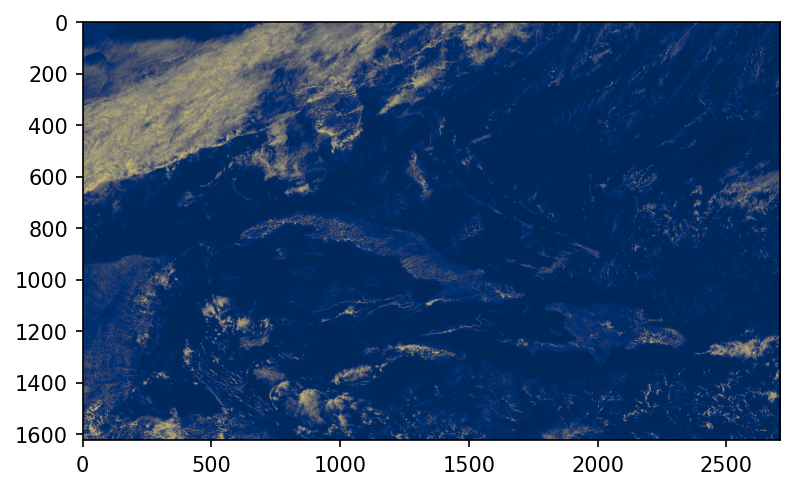

In [20]:
fig = plt.figure(dpi=150)
plt.imshow(cropped_ds.CMI[5], cmap="cividis", origin='upper', vmin=0, vmax=1)

**Crop the CONUS extent to the AOI of the Carribean without resampling the data:**

Functions applied here are provided by Will Jones, check [Example Notebooks](https://github.com/w-k-jones/example_notebooks) for further information.

In [ ]:
# Selecting a Bounding Box based on Lat- and Lon-Coordinates:
ll_bbox=(-70,10,-55,20) #xmin,ymin,xmax,ymax

In [ ]:
# Functions for getting GOES Projection Properties and respective Lon-/Lat-Values 
def get_abi_proj(dataset):
    return Proj(proj='geos', h=dataset.goes_imager_projection.perspective_point_height,
                lon_0=dataset.goes_imager_projection.longitude_of_projection_origin,
                lat_0=dataset.goes_imager_projection.latitude_of_projection_origin,
                sweep=dataset.goes_imager_projection.sweep_angle_axis)

def get_abi_lat_lon(dataset, dtype=float):
    p = get_abi_proj(dataset)
    xx, yy = np.meshgrid((dataset.x.data*dataset.goes_imager_projection.perspective_point_height).astype(dtype),
                         (dataset.y.data*dataset.goes_imager_projection.perspective_point_height).astype(dtype))
    lons, lats = p(xx, yy, inverse=True)
    lons[lons>=1E30] = np.nan
    lats[lats>=1E30] = np.nan
    return lats, lons

In [ ]:
# Function for cropping based on the Bounding Box by transforming the coordinates within the AOI 
# to GOES native coordinates: 
def ll_bound(abi_ds, ll_bbox):
    geo_p = get_abi_proj(abi_ds)
    x, y = geo_p([ll_bbox[0], ll_bbox[0], ll_bbox[2], ll_bbox[2]], 
                 [ll_bbox[1], ll_bbox[3], ll_bbox[1], ll_bbox[3]])
    
    x = [xi if np.isfinite(xi) else np.nan for xi in x]
    y = [yi if np.isfinite(yi) else np.nan for yi in y]
    
    xy_bbox = (np.nanmin(x)/abi_ds.goes_imager_projection.perspective_point_height, 
               np.nanmin(y)/abi_ds.goes_imager_projection.perspective_point_height, 
               np.nanmax(x)/abi_ds.goes_imager_projection.perspective_point_height, 
               np.nanmax(y)/abi_ds.goes_imager_projection.perspective_point_height)
    
    return abi_ds.isel({'x':np.logical_and(abi_ds.x>xy_bbox[0], abi_ds.x<xy_bbox[2]),
                        'y':np.logical_and(abi_ds.y>xy_bbox[1], abi_ds.y<xy_bbox[3])})

In [ ]:
# Apply cropping function to data set:
DS_BB = ll_bound(DS, ll_bbox)

In [ ]:
from mpl_toolkits.basemap import Basemap 

In [ ]:
# Plot AOI extent with GOES projection:
plt.figure(figsize=(16,8))
bmap = Basemap(llcrnrlon=-75,llcrnrlat=10,urcrnrlon=-55,urcrnrlat=30,
             resolution='i', projection='laea', lat_0 = 0, lon_0 = -75.0)

bmap.imshow(cropped_ds["CMI"][0], origin='upper', vmin=0, vmax=1, cmap='cividis')
#bmap.drawcoastlines(linewidth=0.5, linestyle='solid', color='white')
#bmap.drawcountries(linewidth=0.5, linestyle='solid', color='white')
#bmap.drawparallels(np.arange(8,22,2),labels=[1,0,0,0])
#bmap.drawmeridians(np.arange(-70,-50,2),labels=[0,0,0,1])
bmap.colorbar(location='right', label='Reflectance')

**Data manipulation:**
Set up directories and convert coordinates to more a convenient lat-/lon-format.

In [21]:
# Set up directory to save output and plots:
savedir='Save'
if not os.path.exists(savedir):
    os.makedirs(savedir)
plot_dir="Plot"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [22]:
# Rename Attributes (standard_name is a given argument for iris_cube function):
cropped_ds.CMI.attrs["standard_name"] = "toa_bidirectional_reflectance"
print(cropped_ds.CMI.attrs)

{'long_name': 'ABI L2+ Cloud and Moisture Imagery reflectance factor', 'standard_name': 'toa_bidirectional_reflectance', 'sensor_band_bit_depth': 12, 'valid_range': array([   0, 4095], dtype=int16), 'units': '1', 'resolution': 'y: 0.000014 rad x: 0.000014 rad', 'grid_mapping': 'goes_imager_projection', 'cell_methods': 't: point area: point', 'ancillary_variables': 'DQF'}


In [ ]:
# Assign former coordinates as variables to avoid dupplicate naming:
#new_data = cropped_ds.reset_coords(names = ["y_image", "x_image", "band_wavelength"])

**Feature identification:**
Identify features based on OLR field and a set of threshold values.

In [23]:
# Determine temporal and spatial sampling of the input data:
dxy,dt=tobac.utils.get_spacings(cropped_ds.CMI,grid_spacing=500)

In [24]:
# Keyword arguments for the feature detection step
parameters_features={}
parameters_features['position_threshold']='weighted_diff'
parameters_features['sigma_threshold']=0.5
parameters_features['min_num']=10
parameters_features['target']='maximum'
parameters_features['threshold']=0.75

In [25]:
# Feature detection and save results to file:
print('starting feature detection')
Features=tobac.themes.tobac_v1.feature_detection_multithreshold(cropped_ds.CMI,dxy,**parameters_features)
print('feature detection performed and saved')

starting feature detection
      frame   idx       hdim_1       hdim_2  num  threshold_value  feature  \
0         0     1     2.626347  1562.038457   33             0.75        1   
1         0     2     1.093790  1425.553106    3             0.75        2   
2         0     3     1.000000  1466.000000    1             0.75        3   
3         0     4     3.622067  1422.000000    2             0.75        4   
4         0     5     3.000000  1458.000000    1             0.75        5   
...     ...   ...          ...          ...  ...              ...      ...   
7073      5  1017  1617.000000   338.235458    2             0.75     7074   
7074      5  1018  1618.278943   536.817449   11             0.75     7075   
7075      5  1019  1619.296206   332.351047   13             0.75     7076   
7076      5  1020  1621.000000   342.624903    2             0.75     7077   
7077      5  1021  1624.000000    10.000000    1             0.75     7078   

                     time           

In [26]:
Features.to_netcdf(os.path.join(savedir,'Features.nc'))

**Segmentation:**  
Segmentation is performed based on the OLR field and a threshold value to determine the cloud areas.

In [27]:
# Keyword arguments for the segmentation step:
parameters_segmentation={}
parameters_segmentation['target']='maximum'
parameters_segmentation['method']='watershed'
parameters_segmentation['threshold']=0.75

In [28]:
# Perform segmentation and save results to files:
Mask_VIS,Features_VIS=tobac.themes.tobac_v1.segmentation(Features,cropped_ds.CMI,dxy,**parameters_segmentation)
print('segmentation VIS performed, start saving results to files')          
print('segmentation VIS performed and saved')

<xarray.DataArray 'CMI' (t: 6, y: 1625, x: 2709)>
array([[[0.12095226, 0.11968242, 0.1158729 , ..., 0.0380952 ,
         0.03587298, 0.03619044],
        [0.09587292, 0.09523801, 0.08793642, ..., 0.03873012,
         0.0365079 , 0.03523806],
        [0.11174592, 0.11174592, 0.10666656, ..., 0.03777774,
         0.03460314, 0.03777774],
        ...,
        [0.39682502, 0.2095236 , 0.7517453 , ..., 0.0365079 ,
         0.03746028, 0.04222218],
        [0.3168251 , 0.19841251, 0.5412693 , ..., 0.03841266,
         0.04063488, 0.0365079 ],
        [0.27682513, 0.3634917 , 0.3825393 , ..., 0.03587298,
         0.04317456, 0.03873012]],

       [[0.11746021, 0.11365069, 0.1142856 , ..., 0.04888884,
         0.0492063 , 0.04476186],
        [0.09523801, 0.09269832, 0.09174594, ..., 0.04476186,
         0.04539678, 0.04380948],
        [0.10857133, 0.10666656, 0.10825387, ..., 0.04666662,
         0.04730154, 0.04380948],
...
        [0.10857133, 0.08952373, 0.30761877, ..., 0.03873012,
     

In [29]:
Features_VIS.to_netcdf(os.path.join(savedir,'Features_VIS.nc'))
Mask_VIS.to_netcdf(os.path.join(savedir,'Mask_Segmentation_VIS.nc'))    

**Trajectory linking:**
The detected features are linked into cloud trajectories using the trackpy library (http://soft-matter.github.io/trackpy). This takes the feature positions determined in the feature detection step into account but does not include information on the shape of the identified objects.

In [30]:
# keyword arguments for linking step
parameters_linking={}
parameters_linking['v_max']=50
parameters_linking['stubs']=3
parameters_linking['order']=1
parameters_linking['extrapolate']=1
parameters_linking['memory']=0
parameters_linking['adaptive_stop']=0.2
parameters_linking['adaptive_step']=0.95
parameters_linking['subnetwork_size']=100
parameters_linking['method_linking']= 'predict'

In [31]:
# Perform linking and save results to file:
Track=tobac.themes.tobac_v1.linking_trackpy(Features,cropped_ds.CMI,dt=dt,dxy=dxy,**parameters_linking)
Track.to_netcdf(os.path.join(savedir,'Track.nc'))

Frame 5: 1021 trajectories present.


In [4]:
Track = xarray.open_dataset("./Save/Track.nc")

**Visualisation:** 

In [32]:
from mpl_toolkits.basemap import Basemap

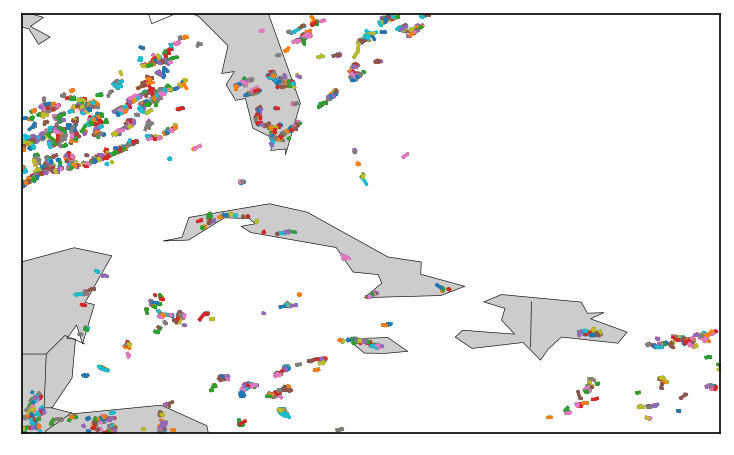

In [46]:
plt.figure(dpi=150)
tmap = Basemap(
    llcrnrlon=-90,llcrnrlat=15,urcrnrlon=-65,urcrnrlat=30,
    projection='cyl',
    lon_0 = -75.0, lat_0=0)
tmap.fillcontinents()
tmap.drawcoastlines(linewidth=0.3, linestyle='solid', color='black')
tmap.drawcountries(linewidth=0.3, linestyle='solid', color='black')

cell_id = np.unique(Track["cell"])
cell_id = cell_id.tolist()
cell_id = [x for x in cell_id if ~np.isnan(x)]
#cell_id = cell_id[0:4500]

for cell in cell_id:  
 track_i = Track.where(Track["cell"]==cell, drop=True)
 x,y = track_i['longitude'].values.tolist(), track_i['latitude'].values.tolist()
 x,y = tmap(x,y)
 tmap.plot(x,y,"--",markersize=.5,latlon=True)

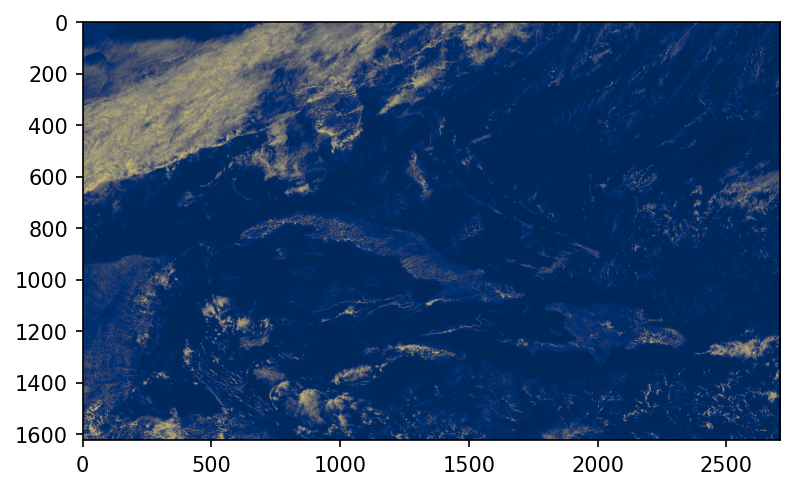

In [35]:
fig = plt.figure(dpi=150)
plt.imshow(cropped_ds.CMI[5], cmap="cividis", origin='upper', vmin=0, vmax=1)

In [50]:
# plotting script, row 299 - onwards (order?)
axis_extent=[-90,-80,25,30] #xmin,xmax,ymin,ymax

In [51]:
# Create animation of tracked clouds and outlines with OLR as a background field
animation_test_tobac=tobac.plot.animation_mask_field(Track,Features,cropped_ds.CMI,Mask_VIS,
                                          axis_extent=axis_extent,#figsize=figsize,orientation_colorbar='horizontal',pad_colorbar=0.2,
                                          vmin=0,vmax=1,cmap='Blues_r',
                                          plot_outline=True,plot_marker=True,marker_track='x',plot_number=True,plot_features=True)

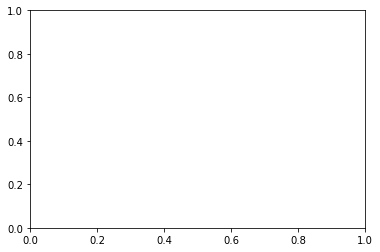

In [52]:
# Display animation:
from IPython.display import HTML, Image, display
HTML(animation_test_tobac.to_html5_video())

Text(0, 0.5, 'counts')

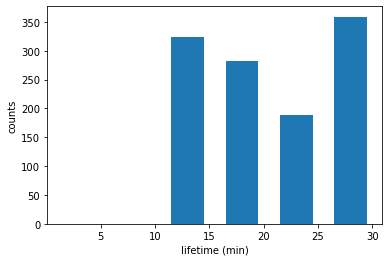

In [54]:
# Lifetimes of tracked clouds:
fig_lifetime,ax_lifetime=plt.subplots()
tobac.plot.plot_lifetime_histogram_bar(Track,axes=ax_lifetime,bin_edges=np.arange(0,35,5),density=False,width_bar=3)
ax_lifetime.set_xlabel('lifetime (min)')
ax_lifetime.set_ylabel('counts')